# Distinct epitopes assumption

The `Polyclonal` model assumes that a polyclonal antibody mix can be divided into independent classes of neutralizing antibodies that bind to distinct epitopes without competition. Here we interrogate the validity of this assumption, being cognizant of the observation that realistic epitopes are often overlapping and therefore not distinct. To do this, we draw from statistical mechanics principles to compare the antibody escape fractions predicted by `Polyclonal` and an identically formulated model that instead assumes all epitopes are overlapping.

### 1. Modeling a monoclonal antibody that neutralizes a viral protein

Before we consider the polyclonal antibody case, lets first consider the case of a monoclonal antibody that neutralizes a viral protein. Here, the viral protein can exist in two microstates, bound or unbound by a neutralizing antibody. The Boltzmann weight is 1 for the unbound state and $\frac{c}{K_d}$ for the bound state, where $c$ is the antibody concentration and $K_d$ is the dissociation constant of antibody-protein binding. These Boltzmann weights can derived using the steady-state approximation (see [Einav et al. 2020](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007830)).

We can then define the partition function $\Xi$ as:

$$ \Xi = \sum_{i} Z_{i} = Z_{unbound} + Z_{bound}$$ 

where $Z_{i}$ represents the Boltzmann weights of the $i$ microstates. Thus, the probability of a viral protein being unbound by a neutralizing antibody, or in other words the **escape fraction**, is:

$$ p_{unbound} = \frac{Z_{unbound}}{\Xi} = \frac{1}{1 + \frac{c}{K_d}} \tag{Eq. 1}$$ 


### 2. Modeling polyclonal antibodies that neutralize a viral protein

To extend above to a polyclonal antibody mix, we first modify $c$ to represent the concentration of the polyclonal antibody mix. We assume that the polyclonal antibody mix contains neutralizing antibodies that bind one of $E$ epitopes. As follows, the Boltzmann weight of the state where epitope $e$ is bound is modified to $\frac{c f_e}{K_{d,e}}$, where $f_e$ represents the fraction of neutralizing antibodies in the polyclonal mix that target epitope $e$, and $K_{d,e}$ is the dissociation constant of neutralizing antibodies binding to epitope $e$. 

#### 2.1 Two distinct epitopes

In a polyclonal antibody mix, it now becomes possible for new microstates to exist where multiple epitopes are bound by antibodies. For example, we can consider a viral protein that contains two distinct epitopes (1 and 2) that are targeted by polyclonal antibodies. In addition to the microstates where a *single* epitope is bound, we now require an additional microstate where *both* epitopes are bound. The Boltzmann weight for this new microstate is: 

$$ Z_{12,bound} = \left(\frac{c f_1}{K_{d,1}}\right) \left(\frac{c f_2}{K_{d,2}}\right)$$

Thus, we can rewrite the partition function $\Xi$ as:

$$ \Xi = \sum_{i} Z_{i} = Z_{unbound} + Z_{1, bound} + Z_{2, bound} + Z_{12, bound}$$

and the probability of a viral protein being unbound by neutralizing antibodies is:

$$
\begin{eqnarray}
p_{unbound} = \frac{Z_{unbound}}{\Xi} &=& \frac{1}{1 + \frac{c f_1}{K_{d,1}} + \frac{c f_2}{K_{d,2}} + \left(\frac{c f_1}{K_{d,1}}\right) \left(\frac{c f_2}{K_{d,2}}\right)} \\
&=& \left(\frac{1}{1 + \frac{c f_1}{K_{d,1}}}\right) \left(\frac{1}{1 + \frac{c f_2}{K_{d,2}}}\right) \tag{Eq. 2} \\
\end{eqnarray}
$$

Note that Eq. 2 exactly corresponds to the `Polyclonal` model.

#### 2.2 Two overlapping epitopes

In the above case, the two epitopes were *distinct* and there was no competition amongst neutralizing antibodies. However, if the epitopes are overlapping and there is competition, then the microstate where *both* epitopes are bound ($Z_{12,bound}$) can no longer happen. In this case, the probability of a viral protein being unbound by antibodies is: 

$$ p_{unbound} = \frac{Z_{unbound}}{\Xi} = \frac{1}{1 + \frac{c f_1}{K_{d,1}} + \frac{c f_2}{K_{d,2}}} \tag{Eq. 3}$$

Using Eq. 2 and Eq. 3, we can see how $p_{unbound}$ varies due to $c$, $f_{1}$, $f_{2}$, $K_{d,1}$, and $K_{d,2}$ under both the distinct and overlapping epitopes assumptions when there are two epitopes.

First, we'll plot the $p_{unbound}$ curves as a function of $c$ when the two classes of antibodies have the same affinities ($K_{d,1} = K_{d,2} = 10^{-6}$). Then, we'll plot the same curve for when the the two classes of antibodies have slightly different affinities ($K_{d,1} = 10^{-7}$, $K_{d,2} = 10^{-5}$). For both plots, we'll assume the two classes of antibodies are present in equal proportion in the sera ($f_1 = f_2 = 0.5$).

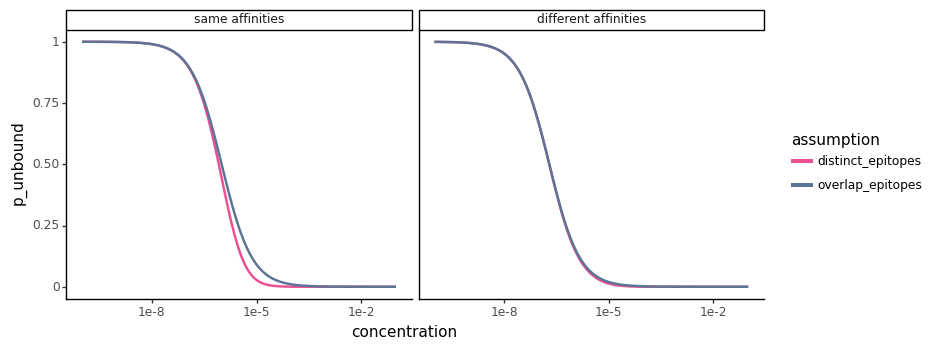

In [1]:
import numpy as np
import pandas as pd
from plotnine import *

n_points = 100

df = (
    pd.DataFrame(
        {
            "c": np.tile(np.logspace(-10, -1, n_points), 2),
            "k_d_1": np.append(np.repeat(1e-6, n_points), np.repeat(1e-5, n_points)),
            "k_d_2": np.append(np.repeat(1e-6, n_points), np.repeat(1e-7, n_points)),
            "f_1": np.repeat(0.5, 2 * n_points),
            "f_2": np.repeat(0.5, 2 * n_points),
            "scenario": (["same affinities"] * n_points)
            + (["different affinities"] * n_points),
        }
    )
    .assign(
        distinct_epitopes=lambda x: (1 / (1 + x.c * x.f_1 / x.k_d_1))
        * (1 / (1 + x.c * x.f_2 / x.k_d_2)),
        overlap_epitopes=lambda x: (
            1 / (1 + x.c * x.f_1 / x.k_d_1 + x.c * x.f_2 / x.k_d_2)
        ),
    )
    .melt(
        id_vars=["c", "k_d_1", "k_d_2", "f_1", "f_2", "scenario"],
        value_vars=["overlap_epitopes", "distinct_epitopes"],
        var_name="assumption",
        value_name="p_unbound",
    )
)

df["scenario"] = (
    df["scenario"]
    .astype("category")
    .cat.reorder_categories(["same affinities", "different affinities"])
)

p = (
    ggplot(df, aes(x="c", y="p_unbound"))
    + geom_line(aes(color="assumption"), size=1)
    + facet_wrap("scenario")
    + labs(x="concentration")
    + scale_color_manual(values=["#ec5094", "#5c7594"])
    + scale_x_log10()
    + theme_classic()
    + theme(figure_size=(9, 3.5))
)

_ = p.draw()

There is a small range in the sera concentration where the curves will slightly differ when the two classes of antibodies have the same affinity ($K_{d,1} = K_{d,2} = 10^{-6}$) for their epitopes. However in general, and when the affinities of the two classes of antibodies start to differ ($K_{d,1} = 10^{-7}$, $K_{d,2} = 10^{-5}$), the two curves are quite concordant.

We can show that this is true across the range of parameters $c$, $f_{1}$, $f_{2}$, $K_{d,1}$, and $K_{d,2}$. You can toggle each parameter to visualize the how it affects `p_unbound` under each assumption.

In [2]:
import altair as alt
from itertools import product

c_range = np.logspace(-8, -2, 4)
Kds = np.logspace(-8, -2, 4)
fracs = np.array([0, 0.25, 0.5, 0.75, 1])

df = (
    pd.DataFrame(
        list(product(c_range, Kds, Kds, fracs, fracs)),
        columns=["c", "k_d_1", "k_d_2", "f_1", "f_2"],
    )
    .assign(f_sum=lambda x: x.f_1 + x.f_2)
    .query("f_sum == 1")
    .assign(
        distinct_epitopes=lambda x: (
            (1 / (1 + x.c * x.f_1 / x.k_d_1)) * (1 / (1 + x.c * x.f_2 / x.k_d_2))
        ).round(3),
        overlap_epitopes=lambda x: (
            (1 / (1 + x.c * x.f_1 / x.k_d_1 + x.c * x.f_2 / x.k_d_2))
        ).round(3),
        log_c=lambda x: np.log10(x.c).astype(int),
        log_k_d_1=lambda x: np.log10(x.k_d_1).astype(int),
        log_k_d_2=lambda x: np.log10(x.k_d_2).astype(int),
    )
    .melt(
        id_vars=["log_c", "log_k_d_1", "log_k_d_2", "f_1", "f_2"],
        value_vars=["overlap_epitopes", "distinct_epitopes"],
        var_name="assumption",
        value_name="p_unbound",
    )
)

c_slider = alt.binding_range(min=-8, max=-2, step=2, name="log(sera concentration): ")
c_filter = alt.selection_point(fields=["log_c"], bind=c_slider, value=-6)

k_d_1_slider = alt.binding_range(min=-8, max=-2, step=2, name="log(antibody 1 Kd): ")
k_d_1_filter = alt.selection_point(fields=["log_k_d_1"], bind=k_d_1_slider, value=-6)

k_d_2_slider = alt.binding_range(min=-8, max=-2, step=2, name="log(antibody 2 Kd): ")
k_d_2_filter = alt.selection_point(fields=["log_k_d_2"], bind=k_d_2_slider, value=-6)

f_1_slider = alt.binding_range(min=0, max=1, step=0.25, name="antibody 1 fraction: ")
f_1_filter = alt.selection_point(fields=["f_1"], bind=f_1_slider, value=0.5)

alt.Chart(df).mark_bar().encode(
    x=alt.X("p_unbound:Q", scale=alt.Scale(domain=[0, 1])),
    y=alt.Y("assumption:O", axis=alt.Axis(title="")),
    color=alt.Color(
        "assumption:O",
        legend=None,
        scale=alt.Scale(
            domain=["distinct_epitopes", "overlap_epitopes"],
            range=["#ec5094", "#5c7594"],
        ),
    ),
    tooltip=["assumption:O", "p_unbound:O"],
).add_params(f_1_filter, k_d_2_filter, k_d_1_filter, c_filter).transform_filter(
    f_1_filter
).transform_filter(
    k_d_2_filter
).transform_filter(
    k_d_1_filter
).transform_filter(
    c_filter
).properties(
    height=60, width=400, title="p_unbound in a two-epitope model"
)

alt.Chart(...)

#### 2.3 Extending beyond two epitopes

The same logic applies to viral proteins with more than two epitopes targeted by neutralizing antibodies. For example, we can write the case of 3 distinct epitopes as:

$$\begin{eqnarray}
p_{unbound} = \frac{Z_{unbound}}{\Xi} &=& \frac{1}{1 + \frac{c f_1}{K_{d,1}} + \frac{c f_2}{K_{d,2}} + \frac{c f_3}{K_{d,3}} + \left(\frac{c f_1}{K_{d,1}}\right) \left(\frac{c f_2}{K_{d,2}}\right) + \left(\frac{c f_1}{K_{d,1}}\right) \left(\frac{c f_3}{K_{d,3}}\right) + \left(\frac{c f_2}{K_{d,2}}\right) \left(\frac{c f_3}{K_{d,3}}\right) + \left(\frac{c f_1}{K_{d,1}}\right) \left(\frac{c f_2}{K_{d,2}}\right) \left(\frac{c f_3}{K_{d,3}}\right)} \\
&=& \left(\frac{1}{1 + \frac{c f_1}{K_{d,1}}}\right) \left(\frac{1}{1 + \frac{c f_2}{K_{d,2}}}\right) \left(\frac{1}{1 + \frac{c f_3}{K_{d,3}}}\right)
\end{eqnarray}$$

and the case of 3 overlapping epitopes as:

$$ p_{unbound} = \frac{Z_{unbound}}{\Xi} = \frac{1}{1 + \frac{c f_1}{K_{d,1}} + \frac{c f_2}{K_{d,2}} + \frac{c f_3}{K_{d,3}}}$$

Again, we can see how the predicted $p_{unbound}$ varies as a function of all parameters under both the distinct and overlapping epitopes assumptions.

In [3]:
c_range = np.logspace(-8, -2, 4)
Kds = np.logspace(-6, -2, 3)
fracs = np.array([0, 0.25, 0.5, 0.75, 1])

df = (
    pd.DataFrame(
        list(product(c_range, Kds, Kds, Kds, fracs, fracs, fracs)),
        columns=["c", "k_d_1", "k_d_2", "k_d_3", "f_1", "f_2", "f_3"],
    )
    .assign(f_sum=lambda x: x.f_1 + x.f_2 + x.f_3)
    .query("f_sum == 1")
    .assign(
        distinct_epitopes=lambda x: (
            (1 / (1 + x.c * x.f_1 / x.k_d_1))
            * (1 / (1 + x.c * x.f_2 / x.k_d_2))
            * (1 / (1 + x.c * x.f_3 / x.k_d_3))
        ).round(3),
        overlap_epitopes=lambda x: (
            (
                1
                / (
                    1
                    + x.c * x.f_1 / x.k_d_1
                    + x.c * x.f_2 / x.k_d_2
                    + x.c * x.f_3 / x.k_d_3
                )
            )
        ).round(3),
        log_c=lambda x: np.log10(x.c).astype(int),
        log_k_d_1=lambda x: np.log10(x.k_d_1).astype(int),
        log_k_d_2=lambda x: np.log10(x.k_d_2).astype(int),
        log_k_d_3=lambda x: np.log10(x.k_d_3).astype(int),
    )
    .melt(
        id_vars=["log_c", "log_k_d_1", "log_k_d_2", "log_k_d_3", "f_1", "f_2", "f_3"],
        value_vars=["overlap_epitopes", "distinct_epitopes"],
        var_name="assumption",
        value_name="p_unbound",
    )
)

c_slider = alt.binding_range(min=-8, max=-2, step=2, name="log(sera concentration): ")
c_filter = alt.selection_point(fields=["log_c"], bind=c_slider, value=-4)

k_d_1_slider = alt.binding_range(min=-6, max=-2, step=2, name="log(antibody 1 Kd): ")
k_d_1_filter = alt.selection_point(fields=["log_k_d_1"], bind=k_d_1_slider, value=-4)

k_d_2_slider = alt.binding_range(min=-6, max=-2, step=2, name="log(antibody 2 Kd): ")
k_d_2_filter = alt.selection_point(fields=["log_k_d_2"], bind=k_d_2_slider, value=-4)

k_d_3_slider = alt.binding_range(min=-6, max=-2, step=2, name="log(antibody 3 Kd): ")
k_d_3_filter = alt.selection_point(fields=["log_k_d_3"], bind=k_d_3_slider, value=-4)

f_1_slider = alt.binding_range(min=0, max=1, step=0.25, name="antibody 1 fraction: ")
f_1_filter = alt.selection_point(fields=["f_1"], bind=f_1_slider, value=0.5)

f_2_slider = alt.binding_range(min=0, max=1, step=0.25, name="antibody 2 fraction: ")
f_2_filter = alt.selection_point(fields=["f_2"], bind=f_2_slider, value=0.5)

alt.Chart(df).mark_bar().encode(
    x=alt.X("p_unbound:Q", scale=alt.Scale(domain=[0, 1])),
    y=alt.Y("assumption:O", axis=alt.Axis(title="")),
    color=alt.Color(
        "assumption:O",
        legend=None,
        scale=alt.Scale(
            domain=["distinct_epitopes", "overlap_epitopes"],
            range=["#ec5094", "#5c7594"],
        ),
    ),
    tooltip=["assumption:O", "p_unbound:O"],
).add_params(
    f_2_filter, f_1_filter, k_d_3_filter, k_d_2_filter, k_d_1_filter, c_filter
).transform_filter(
    f_2_filter
).transform_filter(
    f_1_filter
).transform_filter(
    k_d_3_filter
).transform_filter(
    k_d_2_filter
).transform_filter(
    k_d_1_filter
).transform_filter(
    c_filter
).properties(
    height=60, width=400, title="p_unbound in a three-epitope model"
)

alt.Chart(...)